# San Diego Downtown Parking Model and Predictor

As an intelligent data analyst/scientist creating the **`intuitive data visualzation`**, a good habit is to start with the settings of plotting toolboxes, `matplotlib` and `seaborn`


In [250]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", color_codes=True, font_scale=0.75)
matplotlib.rcParams['figure.dpi'] = 144


Another good habit is to list the used Python library at the top


In [164]:
import os
import glob
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium


There are *3 consequent jupyter notebooks* in this modeling activity presenting the end-to-end flow. On each notebook, including the method and the assumption, the code could be investigated and further re-factored. I present and go through the code matching my best understanding so far.

1. `Data Collection and Visualization`
2. `Data Investigation and Wrangle/Clean`
3. `Prediction Model Build and Performance`


This notebook contains the section of investigating details of data and wrangling, presenting the partial development of end-to-end flow. The detailed notebook is divided into the following sections:

1. **`Data Investigation`**
2. **`Data Wrangle and Clean`**
3. **`Data Visualization`**


## Data Investigation


In this section, we will load and investigate 2018 parking data from the first jypter notebook, *`Data Collection and Visualization`*


In [4]:
df_loc_2018 = pd.read_pickle('./data_saved/2018_parking_locations.pkl')
df_loc_2018.head()

,zone,area,sub_area,config_id,config_name,longitude,latitude
1-1004,Downtown,Core - Columbia,1000 FIRST AVE,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.163929,32.715904
1-1006,Downtown,Core - Columbia,1000 FIRST AVE,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.163930,32.716037
1-1008,Downtown,Core - Columbia,1000 FIRST AVE,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.163931,32.716169
1-1020,Downtown,Core - Columbia,1000 FIRST AVE,9115,15 Min Max $1.25 HR 8am-6pm Mon-Sat,-117.161278,32.717890
1-1310,Downtown,Core - Columbia,1300 FIRST AVE,12466,2 Hour Max $1.25 HR 8am-4pm Mon-Fri 8am-6pm Sat,-117.163951,32.719024


In [8]:
df_tran_2018 = pd.read_pickle('./data_saved/2018_transactions.pkl', compression='gzip')
df_tran_2018.head()

,uuid,meter_type,pole_id,trans_amt,pay_method,trans_start,meter_expire
0,SSJ50718010100571650,SS,J-507,50,CASH,2018-01-01 00:57:16,2018-01-01 00:57:16
4131,SSJ507180102092048250,SS,J-507,250,CREDIT CARD,2018-01-02 09:20:48,2018-01-02 12:00:00
13141,SSJ50718010212104925,SS,J-507,25,CASH,2018-01-02 12:10:49,2018-01-02 12:22:49
17371,SSJ50718010213181765,SS,J-507,65,CASH,2018-01-02 13:18:17,2018-01-02 13:49:29
19344,SSJ507180102135049250,SS,J-507,250,CREDIT CARD,2018-01-02 13:50:49,2018-01-02 15:50:49


Find the Parking Spaces in each Area

In [9]:
df_loc_2018.groupby(by='area').size().sort_values(ascending=False)

area
East Village          1039
Bankers Hill           660
Hillcrest              631
Core - Columbia        513
Little Italy           360
Gaslamp                352
Cortez Hill            301
Marina                 245
North Park             116
Mission Hills          107
University Heights      99
Five Points             75
Barrio Logan            34
Talmadge                32
Midtown                 16
Golden Hill             14
Point Loma               8
College                  5
Mission Beach            4
dtype: int64


We would choose *University Heights*, San Diego State University area as the parking study. The following filtered function contains [Pandas](https://pandas.pydata.org/) functions


In [10]:
print(len(df_tran_2018))

9209712


In [11]:
df_loc_2018_sdsu = df_loc_2018[df_loc_2018['area'] == 'University Heights']
df_tran_2018 = df_tran_2018.join(df_loc_2018_sdsu, on='pole_id', how='inner')

In [12]:
print(len(df_tran_2018))
df_tran_2018.head()

132393


,uuid,meter_type,pole_id,trans_amt,pay_method,trans_start,meter_expire,zone,area,sub_area,config_id,config_name,longitude,latitude
58,SSMO173718010109313025,SS,MO-1737,25,CASH,2018-01-01 09:31:30,2018-01-01 09:31:30,Uptown,University Heights,1700 MONROE AVE,8999,1 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.146457,32.759051
1935,SSMO173718010208071225,SS,MO-1737,25,CASH,2018-01-02 08:07:12,2018-01-02 08:19:12,Uptown,University Heights,1700 MONROE AVE,8999,1 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.146457,32.759051
3123,SSMO173718010208494115,SS,MO-1737,15,CASH,2018-01-02 08:49:41,2018-01-02 08:56:53,Uptown,University Heights,1700 MONROE AVE,8999,1 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.146457,32.759051
23929,SSMO1737180102151209125,SS,MO-1737,125,CREDIT CARD,2018-01-02 15:12:09,2018-01-02 16:12:09,Uptown,University Heights,1700 MONROE AVE,8999,1 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.146457,32.759051
27866,SSMO1737180102162711125,SS,MO-1737,125,CREDIT CARD,2018-01-02 16:27:11,2018-01-02 17:27:11,Uptown,University Heights,1700 MONROE AVE,8999,1 Hour Max $1.25 HR 8am-6pm Mon-Sat,-117.146457,32.759051


In [14]:
pole_id_list = df_tran_2018['pole_id'].unique()
print(len(pole_id_list))

99


## Data Wrangle and Clean


In this section, we are highly utilize some of pandas time-series function:

1. `Timestamp`[Pandas Timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)
2. `Timedelta`[Pandas Timedelta](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html)


In [15]:
df_tran_2018['trans_start'] = df_tran_2018['trans_start'].apply(lambda x: pd.Timestamp(x))
df_tran_2018['meter_expire'] = df_tran_2018['meter_expire'].apply(lambda x: pd.Timestamp(x))

We will construct the time-series dataframe on 2018 with every quarter

In [59]:
year2018 = pd.date_range(start='1/2/2018', end='12/25/2018', freq='15T')
df_2018 = pd.DataFrame(index=year2018)
df_2018['Parking'] = 0
df_2018.tail()

,Parking
2018-12-24 23:00:00,0
2018-12-24 23:15:00,0
2018-12-24 23:30:00,0
2018-12-24 23:45:00,0
2018-12-25 00:00:00,0



Have the preprocessing function to fill the collected transaction records into 15mins time-series dataframe.

Note: It will take some time for the re-processing


In [60]:
def time_series(pole_id_list):
    
    for n, pole_id in enumerate(pole_id_list):
        df_tran = df_tran_2018[df_tran_2018['pole_id'] == pole_id]
        start = 0
        print('process pole number ' + str(n))
        
        for i in df_tran.index:
            for j in range(start, len(df_2018)):
                time_delta_start = df_tran.loc[i, 'trans_start'] - df_2018.index[j]
                time_delta_stop = df_tran.loc[i, 'meter_expire'] - df_2018.index[j]
                if time_delta_start == time_delta_stop:
                    break
                std = (time_delta_start/pd.Timedelta('1 min'))*(time_delta_stop/pd.Timedelta('1 min'))
                if std < 0:
                    df_2018.loc[df_2018.index[j], 'Parking'] += 1
                    start = j
                    check_extent = df_tran.loc[i, 'meter_expire'] - df_2018.index[j+1]
                    if (check_extent/pd.Timedelta('1 min')) < 0:
                        break
                        
    return df_2018
    

In [61]:
df_2018_full = time_series(pole_id_list)

process pole number 0
process pole number 1
process pole number 2
process pole number 3
process pole number 4
process pole number 5
process pole number 6
process pole number 7
process pole number 8
process pole number 9
process pole number 10
process pole number 11
process pole number 12
process pole number 13
process pole number 14
process pole number 15
process pole number 16
process pole number 17
process pole number 18
process pole number 19
process pole number 20
process pole number 21
process pole number 22
process pole number 23
process pole number 24
process pole number 25
process pole number 26
process pole number 27
process pole number 28
process pole number 29
process pole number 30
process pole number 31
process pole number 32
process pole number 33
process pole number 34
process pole number 35
process pole number 36
process pole number 37
process pole number 38
process pole number 39
process pole number 40
process pole number 41
process pole number 42
process pole number 4

`Save the dataframe as the final time-series data on parking at SDSU region`

In [271]:
df_2018 = df_2018_full

,Parking,Day,Month,Hour,Minute,Holiday,Day of Week
2018-01-02 00:00:00,33.478763,Tuesday,January,0,0,False,1
2018-01-02 00:15:00,33.478763,Tuesday,January,0,15,False,1
2018-01-02 00:30:00,33.478763,Tuesday,January,0,30,False,1
2018-01-02 00:45:00,33.478763,Tuesday,January,0,45,False,1
2018-01-02 01:00:00,33.478763,Tuesday,January,1,0,False,1


In [65]:
df_2018.to_csv('./data_saved/parking_university_heights_2018.csv')

Utilizing transaction records on identifying the parking spotts might not be sutiable for the following non-charged timing due to the parking rules:

1. `U.S. Holidays`
2. `Sunday`
3. `Time from 18:00:00 to 8:00:00`


Identifying US Holidays in 2018

In [67]:
cal = calendar()
holidays = cal.holidays(start='1/1/2018', end='12/31/2018')
holidays = [i.date() for i in holidays]
print(holidays)

[datetime.date(2018, 1, 1), datetime.date(2018, 1, 15), datetime.date(2018, 2, 19), datetime.date(2018, 5, 28), datetime.date(2018, 7, 4), datetime.date(2018, 9, 3), datetime.date(2018, 10, 8), datetime.date(2018, 11, 12), datetime.date(2018, 11, 22), datetime.date(2018, 12, 25)]


In [94]:
df_2018['Day'] = [True if i.date() in holidays else False for i in df_2018.index]

In [98]:
df_2018['Month'] = [i.month_name() for i in df_2018.index]
df_2018['Day'] = [i.day_name() for i in df_2018.index]
df_2018['Hour'] = [i.hour for i in df_2018.index]
df_2018['Minute'] = [i.minute for i in df_2018.index]
df_2018['Holiday'] = [True if i.date() in holidays else False for i in df_2018.index]

In [102]:
print(df_2018.shape)
df_2018.head()

(34273, 6)


,Parking,Day,Month,Hour,Minute,Holiday
2018-01-02 00:00:00,0,Tuesday,January,0,0,False
2018-01-02 00:15:00,0,Tuesday,January,0,15,False
2018-01-02 00:30:00,0,Tuesday,January,0,30,False
2018-01-02 00:45:00,0,Tuesday,January,0,45,False
2018-01-02 01:00:00,0,Tuesday,January,1,0,False


To construct the contineous time-series function, those non-charging timing slotts will be filled by the following rules:

1. `The time-slotts on holidays including Sundays will be filled by the averaged Saturdays time slots`
2. `The time-slotts after 18:00:00 will be filled by the averaged number during the charging timing slotts`


Utilize Pandas [GroupBy](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html) to identify the mean parking number on each time-slots of Saturdays

In [124]:
df_sat = df_2018[df_2018['Day'] == 'Saturday']
df_sat_group = df_sat.groupby(by=['Hour', 'Minute']).mean()

In [125]:
df_sat_group.head()

Parking  Holiday
Hour Minute                  
0    0           0.0    False
     15          0.0    False
     30          0.0    False
     45          0.0    False
1    0           0.0    False

In [129]:
df_sat_group.loc[(1, 30), 'Parking']

0.0

In [141]:
def apply_sat(x):
    if x.Day == 'Sunday':
        return(df_sat_group.loc[(x.Hour, x.Minute), 'Parking'])
    else:
        if x.Holiday == True:
            return(df_sat_group.loc[(x.Hour, x.Minute), 'Parking'])
        else:
            return(x.Parking)

In [142]:
df_2018['Parking'] = df_2018.apply(func=apply_sat, axis=1)

In [147]:
avg = df_2018[(df_2018['Hour'] > 8) & (df_2018['Hour'] < 18)].mean()
print(avg['Parking'])

33.478762746928844


In [159]:
def apply_avg(x):
    if ((x.Hour >= 18) | (x.Hour < 8)):
        return avg['Parking']
    else:
        return(x.Parking)

In [160]:
df_2018['Parking'] = df_2018.apply(func=apply_avg, axis=1)

## Data Visulization


Look at time-series parking data on University Heights


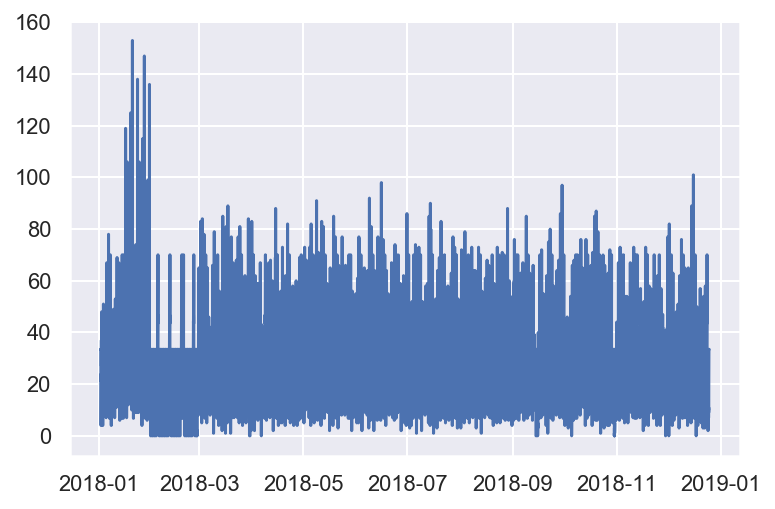

In [248]:
sns.lineplot(data=df_2018['Parking'], )


Zoom-in on every Saturday at January


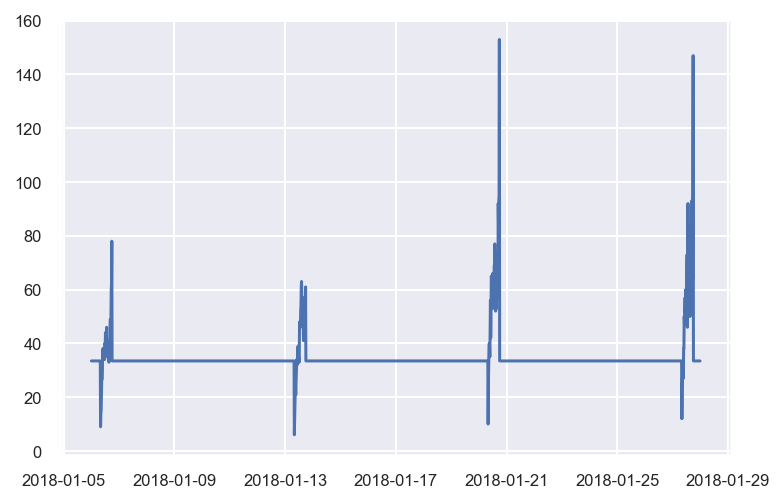

In [251]:
sns.lineplot(data=df_2018[(df_2018['Month'] == 'January') & (df_2018['Day'] == 'Saturday')]['Parking'])


Zoom in on the particular Saturday


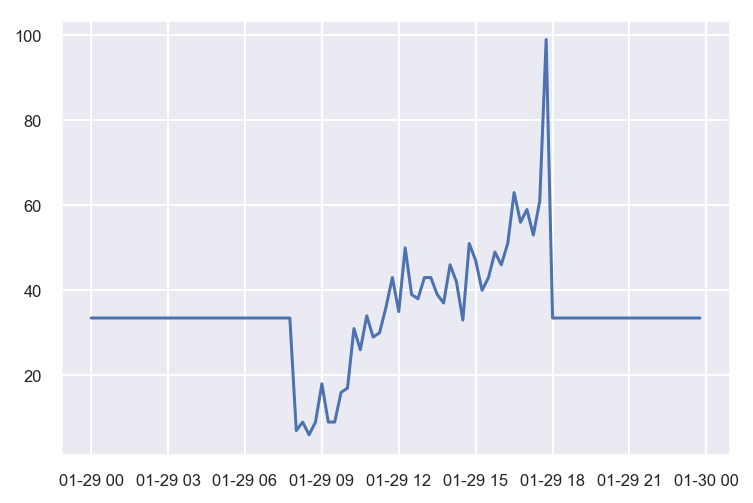

In [255]:
sns.lineplot(data=df_2018[(df_2018['Month'] == 'January') & (df_2018.index.day == 29)]['Parking'])

In [229]:
df_2018['Day of Week'] = [i.dayofweek for i in df_2018.index]
df_2018.head()

,Parking,Day,Month,Hour,Minute,Holiday,Day of Week
2018-01-02 00:00:00,33.478763,Tuesday,January,0,0,False,1
2018-01-02 00:15:00,33.478763,Tuesday,January,0,15,False,1
2018-01-02 00:30:00,33.478763,Tuesday,January,0,30,False,1
2018-01-02 00:45:00,33.478763,Tuesday,January,0,45,False,1
2018-01-02 01:00:00,33.478763,Tuesday,January,1,0,False,1



Look at the averaged hot-spot between Days of Week and Hour on January


In [230]:
df_2018_Jan = df_2018[df_2018['Month'] == 'January']

In [238]:
df_2018_Jan = df_2018_Jan.groupby(by=['Day of Week', 'Hour']).mean()

In [240]:
ht = pd.pivot_table(df_2018_Jan['Parking'].reset_index(), 
                    index='Day of Week',
                    columns='Hour',
                    values='Parking'
                   )

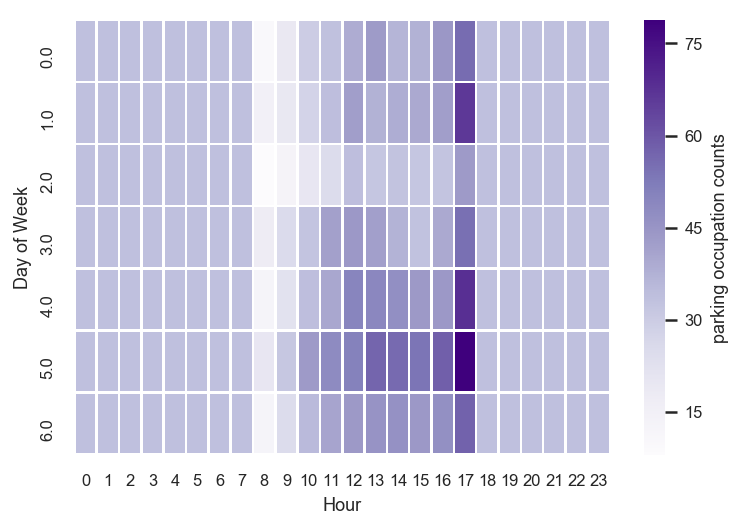

In [263]:
g0 = sns.heatmap(ht, cmap='Purples', annot=False, linewidths=0.8,
                 cbar_kws={'label': 'parking occupation counts'}
                )


Look at the averaged hot-spot between Days of Week and Hour between month


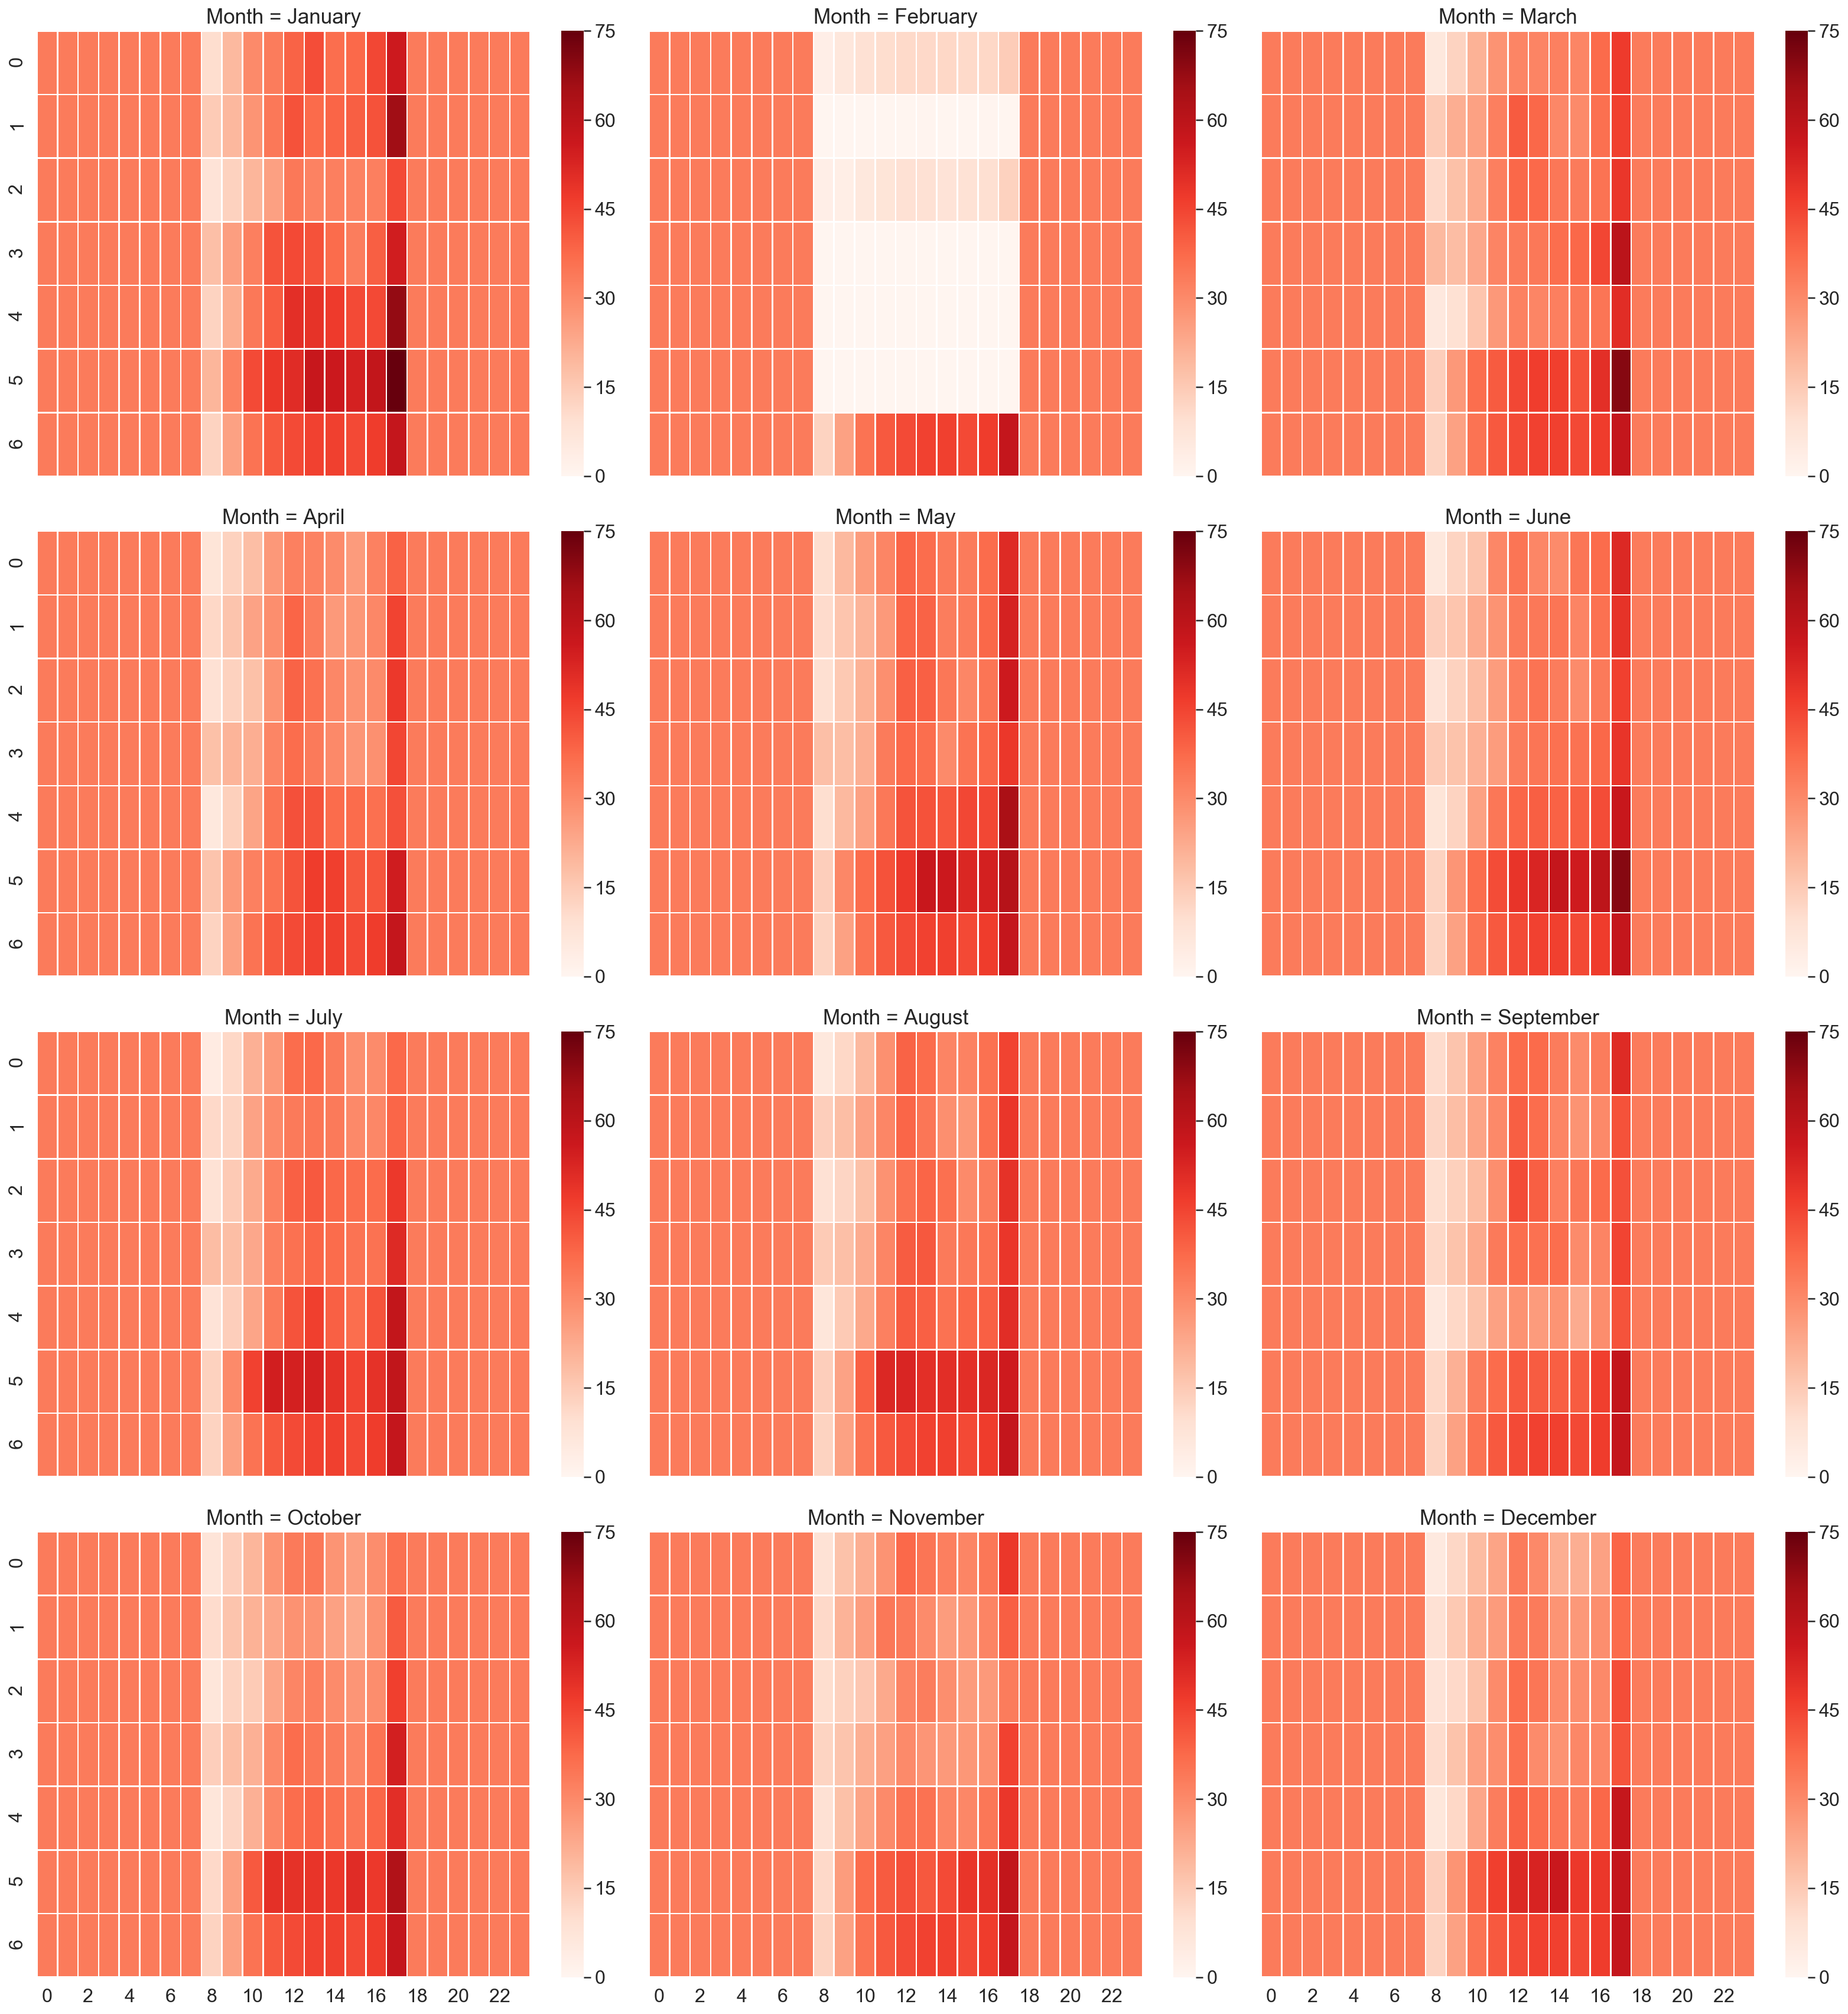

In [268]:
sns.set(style="darkgrid", color_codes=True, font_scale=1.46)
data = df_2018.groupby(by=['Day of Week', 'Hour', 'Month']).mean()

def facet_heatmap(*args, **kwargs): ## Define Plot Function
    data = kwargs.pop('data')
    ht = pd.pivot_table(data=data,
                        index='Day of Week',
                        columns='Hour',
                        values='Parking'
                        )
    sns.heatmap(ht, cmap='Reds', annot=False, linewidths=0.8, vmin=0, vmax=75)

col_order = ['January', 'February', 'March',
             'April', 'May', 'June',
             'July', 'August', 'September',
             'October', 'November', 'December'
            ]
g = sns.FacetGrid(data=data.reset_index(), col='Month', col_wrap=3, col_order=col_order, height=6, aspect=1.25)
g.map_dataframe(func=facet_heatmap)

In [272]:
df_2018.to_csv('./data_saved/parking_university_heights_2018.csv')